# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [57]:
%matplotlib notebook

import logging

from matplotlib import pyplot as plt
from helper import *
logging.basicConfig(level=logging.INFO)
plt.style.use('seaborn-darkgrid')

df_ecdc = ecdc()
logging.info('ECDC: \n%s', df_ecdc.columns)

df_at = at()
logging.info('AT: \n%s', df_at.columns);

INFO:root:ECDC: 
Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')
INFO:root:AT: 
Index(['time', 'tägliche Erkrankungen', 'Timestamp', 'weekday'], dtype='object')


## Comparison with ECDC data

### Number of cases

In [59]:
df_at['tägliche Erkrankungen'].sum(), df_ecdc[df_ecdc.geoId=='AT'].cases.sum()


(52107, 51382)

### Plots overlaid

<IPython.core.display.Javascript object>


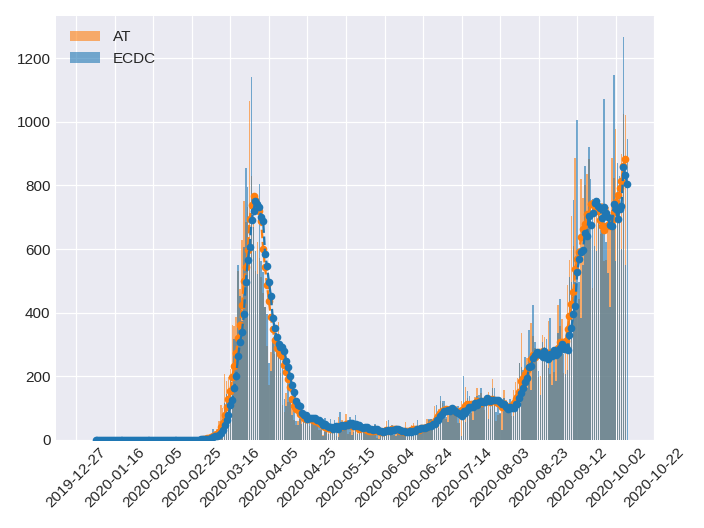

In [14]:
f,ax = plt.subplots()
# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(),  marker='o', markersize=4, linestyle='--', color='C1')

ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='AT',  alpha=0.6, color='C1')
selection = df_ecdc[df_ecdc.geoId=='AT'].sort_values(by=['year','month','day'], ascending=True)
ax.bar(selection.dateRep, selection['cases'],label='ECDC',  alpha=0.6, color='C0')
ax.plot(selection.dateRep, selection['cases'].rolling(7).mean(), marker='o', markersize=4, linestyle='--',color='C0')
# plt.yscale('log')

ax.xaxis.set_major_locator(plt.MaxNLocator(20));

plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()



### Last 5 days

In [61]:
df_ecdc[df_ecdc.geoId=='AT'].sort_values('dateRep')[['dateRep', 'cases', 'deaths','popData2019', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000' ]].tail(6)

,dateRep,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
2552,2020-10-03,872,1,8858775.0,112.859848
2551,2020-10-04,830,6,8858775.0,113.683890
2550,2020-10-05,599,4,8858775.0,113.571007
2549,2020-10-06,1268,5,8858775.0,121.190571
2548,2020-10-07,549,22,8858775.0,118.955499
2547,2020-10-08,947,4,8858775.0,122.183936


In [62]:
df_at.sort_values('time').tail(5)

,time,tägliche Erkrankungen,Timestamp,weekday
221,2020-10-03,711,2020-10-08T10:58:53,5
222,2020-10-04,715,2020-10-08T10:58:53,6
223,2020-10-05,899,2020-10-08T10:58:53,0
224,2020-10-06,1025,2020-10-08T10:58:53,1
225,2020-10-07,1023,2020-10-08T10:58:53,2


In [12]:
df_at.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'time': ['min', 'max']} )


,tägliche Erkrankungen,time
last_7_days_sum,5866.0,NaT
latest,860.0,NaT
max,1065.0,2020-10-06
min,NaN,2020-02-25
rolling_avg,838.0,NaT
sum,50915.0,NaT


In [63]:
overview(df_ecdc[df_ecdc.geoId=='AT'])

cases                                    deaths  \
                           sum last_7_days_sum rolling_avg latest    sum   
countriesAndTerritories                                                    
Austria                  51382            5629         804    947    844   

                                                            
                        last_7_days_sum rolling_avg latest  
countriesAndTerritories                                     
Austria                              45           6      4

## ICU beds

In [21]:
current = 63
total = 246
avg_increase = 4


In [22]:
new = current
for i in range(10):
    new +=  avg_increase
    print(new)

67
71
75
79
83
87
91
95
99
103


In [56]:
import numpy as np
icu_occupancy = np.array([43,44,48,49,52,54,55,54,57,55,52,57,63])
ndays = np.arange(len(icu_occupancy))
future = np.arange(ndays[0],ndays[-1]+len(ndays))
z = np.polyfit(ndays, icu_occupancy, 2)
p = np.poly1d(z)

In [54]:
p(future)

array([44.98901099, 46.24725275, 47.50549451, 48.76373626, 50.02197802,
       51.28021978, 52.53846154, 53.7967033 , 55.05494505, 56.31318681,
       57.57142857, 58.82967033, 60.08791209, 61.34615385, 62.6043956 ,
       63.86263736, 65.12087912, 66.37912088, 67.63736264, 68.8956044 ,
       70.15384615, 71.41208791, 72.67032967, 73.92857143, 75.18681319])

<IPython.core.display.Javascript object>


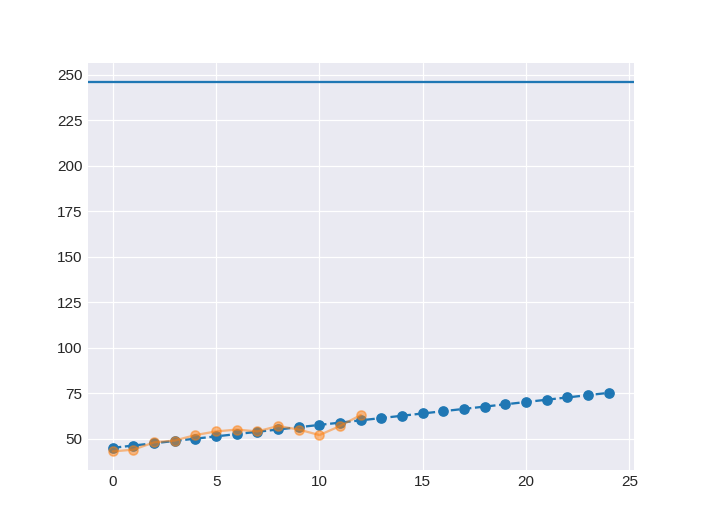

In [55]:
f, ax = plt.subplots()
ax.axhline(y=total)
ax.plot(future, p(future), marker='o', linestyle='--')
ax.plot(ndays, icu_occupancy, label='occupancy', marker='o', alpha=0.5)


## Other datasets

In [82]:
case_numbers = pd.read_csv('https://covid19-dashboard.ages.at/data/CovidFallzahlen.csv', delimiter=';')
print('Case numbers\n', case_numbers.columns)

case_timeline = pd.read_csv('https://covid19-dashboard.ages.at/data/CovidFaelle_Timeline_GKZ.csv', delimiter=';')
print('Case Timeline\n', case_timeline.columns)

Case numbers
 Index(['Meldedat', 'TestGesamt', 'MeldeDatum', 'FZHosp', 'FZICU', 'FZHospFree',
       'FZICUFree', 'BundeslandID', 'Bundesland'],
      dtype='object')
Case Timeline
 Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
       'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
       'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
       'AnzahlGeheiltSum'],
      dtype='object')


In [107]:
df = pd.read_csv('https://covid19-dashboard.ages.at/data/CovidFaelle_Altersgruppe.csv', delimiter=';')
df.head()

,AltersgruppeID,Altersgruppe,Bundesland,BundeslandID,AnzEinwohner,Geschlecht,Anzahl,AnzahlGeheilt,AnzahlTot
0,1,<5,Burgenland,1,6299,M,9,7,0
1,1,<5,Burgenland,1,5852,W,5,4,0
2,1,<5,Kärnten,2,12352,M,6,3,0
3,1,<5,Kärnten,2,11792,W,6,1,0
4,1,<5,Niederösterreich,3,40461,M,40,35,0


### Vienna

In [109]:
wien_cases = case_numbers[case_numbers.Bundesland=='Wien']
wien_cases['MeldeDatum'] = pd.to_datetime(wien_cases['MeldeDatum'].astype(str),
                                   format='%d.%m.%Y %H:%M:%S')
wien_timeline = case_timeline[case_timeline.Bezirk=='Wien']
wien_timeline['Time'] = pd.to_datetime(wien_timeline['Time'].astype(str),
                                   format='%d.%m.%Y %H:%M:%S')


/home/gythaogg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gythaogg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


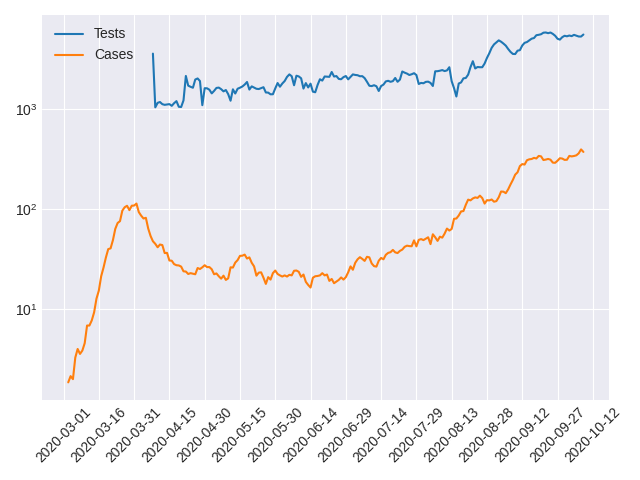

In [160]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Tests')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend(loc='best')
plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

<IPython.core.display.Javascript object>


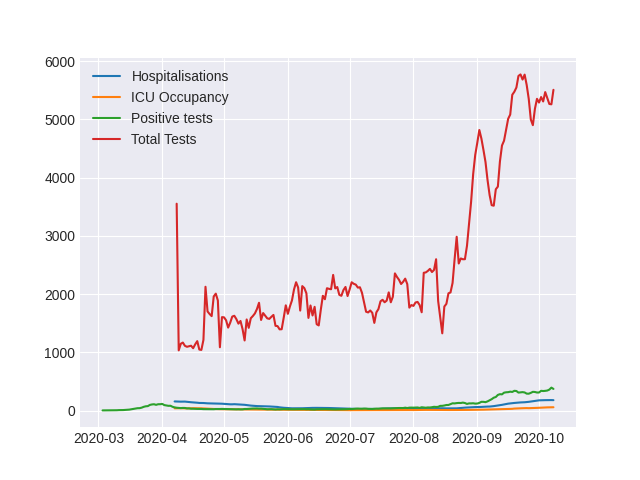

In [139]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')

# ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(), label='Epicurve')
# plt.yscale('log')
plt.legend(loc='best')
#  Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
#        'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
#        'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
#        'AnzahlGeheiltSum'],

#  Index(['Meldedat', 'TestGesamt', 'MeldeDatum', 'FZHosp', 'FZICU', 'FZHospFree','FZICUFree', 'BundeslandID', 'Bundesland'],


In [125]:
df_at.columns

Index(['time', 'tägliche Erkrankungen', 'Timestamp', 'weekday'], dtype='object')

### Ratio of positives to tests

<IPython.core.display.Javascript object>


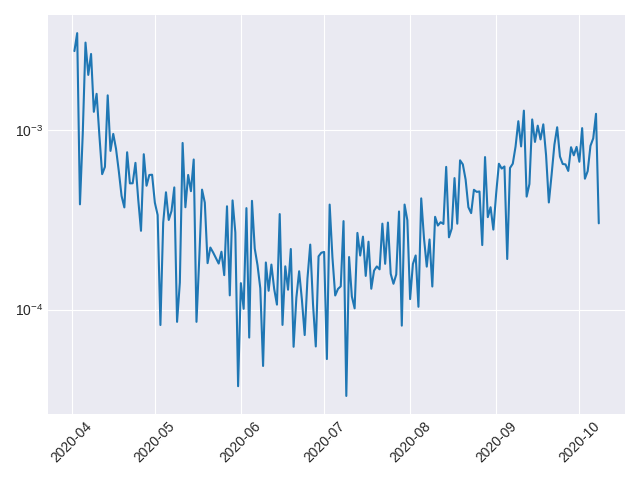

/home/gythaogg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [159]:
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
# ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
# ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')
f,ax=plt.subplots()
ratio = np.array(wien_timeline[wien_timeline.Time.isin(wien_cases.MeldeDatum)].AnzahlFaelle)/np.array(wien_cases.TestGesamt)
ax.plot(wien_cases.MeldeDatum,ratio)
plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

In [153]:
len(wien_cases.TestGesamt.diff())

191

In [154]:
np.array(wien_cases.TestGesamt)

array([     0,  18880,  19618,  20740,  22144,  22798,  23659,  24869,
        26114,  27644,  28912,  29925,  30461,  31391,  32660,  33607,
        35603,  37256,  37256,  37750,  39880,  47541,  45520,  47206,
        48607,  50973,  51804,  53114,  55147,  56750,  58413,  59457,
        60943,  62364,  64413,  66538,  67738,  68859,  70226,  70738,
        70789,  75361,  76478,  78833,  80219,  81902,  82944,  83745,
        86247,  88196,  90228,  91303,  92920,  94212,  95237,  96431,
        98344,  99988, 101078, 104094, 106863, 106863, 108942, 111587,
       114552, 116506, 118882, 118882, 121824, 123664, 125689, 125689,
       129139, 130311, 131352, 132202, 133897, 137799, 139490, 142519,
       145016, 145983, 146786, 150203, 152490, 154337, 156426, 158812,
       160470, 161646, 163969, 167042, 169759, 171663, 173950, 175253,
       176467, 178128, 180057, 181638, 183457, 185980, 187002, 187002,
       189935, 192259, 194771, 196770, 198998, 200218, 201208, 202951,
      